In [3]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import optuna
from optuna.samplers import TPESampler

def transform_features2(df):
    if 'MW' in df.columns:
        df['MW_log'] = np.log1p(df['MW'])  # log(1+x) to avoid log(0)
        df.drop(columns=['MW'], inplace=True)
    
    if "NumOfConfUsed" in df.columns:
        df['NumOfConfUsed_log'] = np.log1p(df['NumOfConfUsed'])
        df['NumOfConfUsed_binned'] = pd.cut(df['NumOfConfUsed'], bins=[0, 10, 20, 30, 40], labels=[1, 2, 3, 4])
        df.drop(columns=['NumOfConfUsed'], inplace=True)
    
    if 'NumOfAtoms' in df.columns:
        df['NumOfAtoms_sqrt'] = np.sqrt(df['NumOfAtoms'])
        df['ConfUsed_to_Atoms'] = df['NumOfConfUsed_log'] / (df['NumOfAtoms'] + 1e-5)  # Avoid division by zero
        df.drop(columns=['NumOfAtoms'], inplace=True)
    
    if 'NumOfN_binned' in df.columns:
        df['NumOfN_binned'] = df['NumOfN_binned'].astype(int)  # Convert categories to integers
    
    if 'NumOfConf' in df.columns:
        df['NumOfConf_log'] = np.log1p(df['NumOfConf'])
        df.drop(columns=['NumOfConf'], inplace=True)

    if 'NumOfConfUsed_binned' in df.columns:
        df['NumOfConfUsed_binned'] = df['NumOfConfUsed_binned'].astype(int)  # Convert categories to integers
        
    df['Conf_to_ConfUsed_ratio'] = df['NumOfConf_log'] / df['NumOfConfUsed_binned']
    df['MW_to_NumOfAtoms'] = df['MW_log'] / df['NumOfAtoms_sqrt']
    df['Experimental11'] = df['NumHBondDonors'] / df['NumOfConf_log'] # addition to best2
    df['Inter1'] = df['NumHBondDonors'] * df['MW_log']
    return df



def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 150),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'cat_smooth': trial.suggest_float('cat_smooth', 1.0, 50.0),
        'random_state': 4,
        'n_jobs': -1
    }
    
    model = lgb.LGBMRegressor(**param, verbose=-1)
    
    kf = KFold(n_splits=10, shuffle=True, random_state=7)
    scores = cross_val_score(model, train_transformed, target, cv=kf, scoring='neg_mean_squared_error')
    return -scores.mean()

# Load data
train = pd.read_csv("../Data/train.csv")
test = pd.read_csv("../Data/test.csv")

# Preserve the ID column
test_ids = test["ID"]

# Drop ID column from test data
test.drop(columns=["ID"], inplace=True)

# Separate target variable from training data
target = train["log_pSat_Pa"]
train.drop(columns=["log_pSat_Pa", "ID"], inplace=True)

# Apply feature engineering
train_transformed = transform_features2(train.copy())
test_transformed = transform_features2(test.copy())

# One-hot encode categorical features "parentspecies" column
train_transformed = pd.get_dummies(train_transformed, columns=["parentspecies"], drop_first=True)
test_transformed = pd.get_dummies(test_transformed, columns=["parentspecies"], drop_first=True)

# Align the columns of train and test data
train_transformed, test_transformed = train_transformed.align(test_transformed, join='left', axis=1, fill_value=0)

# Separate the parentspecies columns
parentspecies_train = train_transformed.filter(like='parentspecies')
parentspecies_test = test_transformed.filter(like='parentspecies')

# Drop the parentspecies columns from the transformed data
train_transformed = train_transformed.drop(columns=parentspecies_train.columns)
test_transformed = test_transformed.drop(columns=parentspecies_test.columns)

# Save the column names before scaling
train_columns = train_transformed.columns
test_columns = test_transformed.columns

# Scale numerical features
scaler = StandardScaler()
train_transformed = scaler.fit_transform(train_transformed)
test_transformed = scaler.transform(test_transformed)

# Convert scaled numerical features back to DataFrame
train_transformed = pd.DataFrame(train_transformed, columns=train_columns)
test_transformed = pd.DataFrame(test_transformed, columns=test_columns)

# Add the parentspecies columns back to the scaled numerical features
train_transformed = pd.concat([train_transformed, parentspecies_train.reset_index(drop=True)], axis=1)
test_transformed = pd.concat([test_transformed, parentspecies_test.reset_index(drop=True)], axis=1)

#best_params = {'n_estimators': 612, 'learning_rate': 0.03253420017567533, 'num_leaves': 123, 'max_depth': 7, 'min_child_samples': 46, 'subsample': 0.7456333280664998, 'colsample_bytree': 0.9137393037318097, 'reg_alpha': 0.7026860907781649, 'reg_lambda': 0.7187304208680759}
study = optuna.create_study(direction='minimize', study_name='last_test_set_iter1',
                            storage="sqlite:///../Data/optuna2.db", load_if_exists=True)
study.optimize(objective, n_trials=150)
print("Best hyperparameters: ", study.best_params)
best_params = study.best_params

model = lgb.LGBMRegressor(**best_params)
model.fit(train_transformed, target)

# Predict on the training set
train_predictions = model.predict(train_transformed)
rmse = mean_squared_error(target, train_predictions, squared=False)
mae = mean_absolute_error(target, train_predictions)
r2 = r2_score(target, train_predictions)
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

# Predict on the test set
test_predictions = model.predict(test_transformed)
output = pd.DataFrame({"ID": test_ids, "TARGET": test_predictions})
output.to_csv("last_test_iteration1.csv", index=False)

# view the feature importance
importance = model.feature_importances_
feature_names = train_transformed.columns
feature_importance = pd.DataFrame({"feature": feature_names, "importance": importance})
feature_importance = feature_importance.sort_values(by="importance", ascending=False)
print(feature_importance)

# plot the feature importance
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importance)
plt.title("Feature Importance")

[I 2024-12-08 18:36:40,458] Using an existing study with name 'last_test_set_iter1' instead of creating a new one.
[I 2024-12-08 18:37:30,934] Trial 0 finished with value: 3.1912998408310496 and parameters: {'n_estimators': 1579, 'learning_rate': 0.31026521263269574, 'num_leaves': 135, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.623228976281031, 'colsample_bytree': 0.6033954231014662, 'reg_alpha': 0.1275733386989113, 'reg_lambda': 0.5178156211582104, 'cat_smooth': 28.01726253700608}. Best is trial 0 with value: 3.1912998408310496.
[I 2024-12-08 18:38:22,179] Trial 1 finished with value: 3.0926230617669708 and parameters: {'n_estimators': 1376, 'learning_rate': 0.2521248611106079, 'num_leaves': 148, 'max_depth': 9, 'min_child_samples': 45, 'subsample': 0.9683054657963096, 'colsample_bytree': 0.9438967800869549, 'reg_alpha': 0.9386784266390094, 'reg_lambda': 0.8253507950769037, 'cat_smooth': 29.245621890945067}. Best is trial 1 with value: 3.0926230617669708.
[I 2024-12-08 18

KeyboardInterrupt: 

/home/saavajuu/anaconda3/envs/iml_env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 1.3540
MAE: 0.9985
R^2: 0.8117
                              feature  importance
28                     Experimental11        3279
25                      NumOfConf_log        3013
24                  ConfUsed_to_Atoms        2794
27                   MW_to_NumOfAtoms        2520
26             Conf_to_ConfUsed_ratio        2506
29                             Inter1        2023
20                             MW_log        1900
21                  NumOfConfUsed_log        1612
0                              NumOfC        1232
8                              ketone         988
6                    hydroxyl (alkyl)         879
1                              NumOfO         812
23                    NumOfAtoms_sqrt         735
7                            aldehyde         731
18                 carbonylperoxyacid         604
17                      hydroperoxide         552
9                     carboxylic acid         543
16                           peroxide         482
15           

Text(0.5, 1.0, 'Feature Importance')

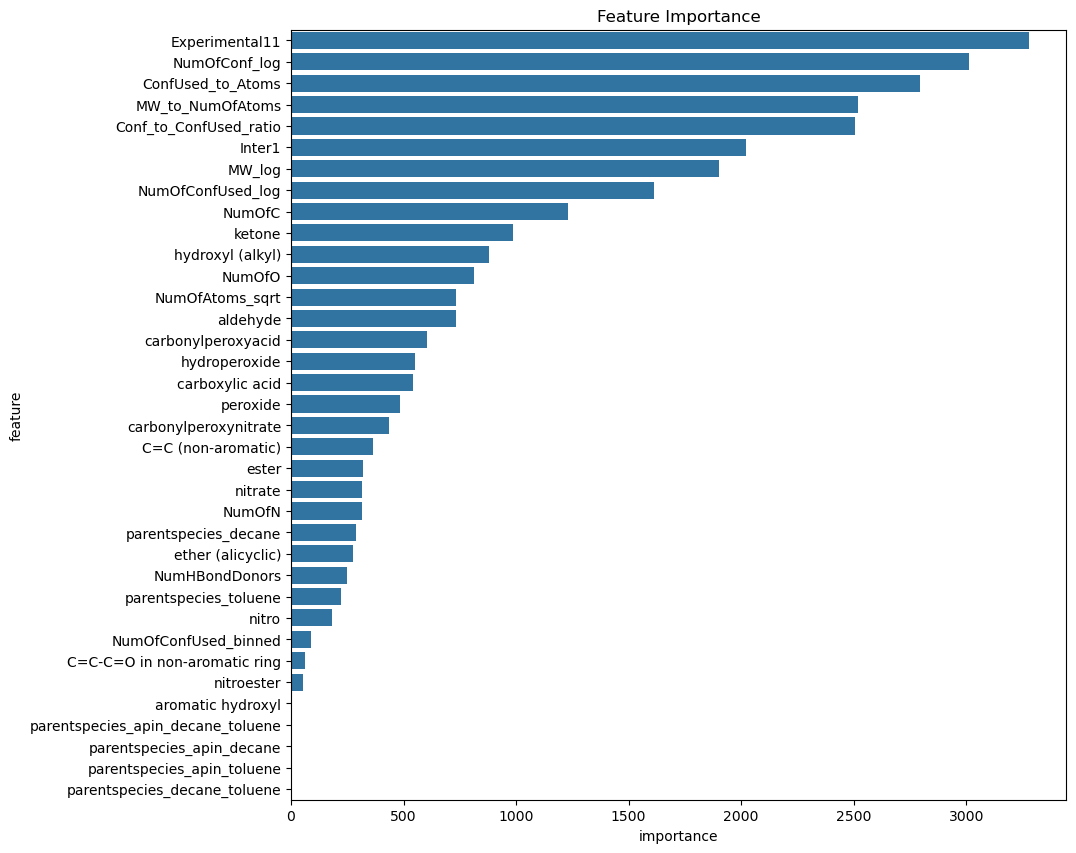

In [4]:
best_params = study.best_params

model = lgb.LGBMRegressor(**best_params)
model.fit(train_transformed, target)

# Predict on the training set
train_predictions = model.predict(train_transformed)
rmse = mean_squared_error(target, train_predictions, squared=False)
mae = mean_absolute_error(target, train_predictions)
r2 = r2_score(target, train_predictions)
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

# Predict on the test set
test_predictions = model.predict(test_transformed)
output = pd.DataFrame({"ID": test_ids, "TARGET": test_predictions})
output.to_csv("lgbm_ROUND2.csv", index=False)

# view the feature importance
importance = model.feature_importances_
feature_names = train_transformed.columns
feature_importance = pd.DataFrame({"feature": feature_names, "importance": importance})
feature_importance = feature_importance.sort_values(by="importance", ascending=False)
print(feature_importance)

# plot the feature importance
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importance)
plt.title("Feature Importance")